In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO
from ipywidgets import widgets
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train=f'{BASE_DIR}/train'
print(f"Train Directory: {sorted(os.listdir(data_train))}")
data_validation=f'{BASE_DIR}/valid'
print(f"Valid Directory: {sorted(os.listdir(data_validation))}")
data_test=f'{BASE_DIR}/test'
print(f"Test Directory: {sorted(os.listdir(data_test))}")

Base Directory: ['test', 'train', 'val']
Train Directory: ['berminyak', 'jerawat', 'normal']
Valid Directory: ['berminyak', 'jerawat', 'normal']
Test Directory: ['berminyak', 'jerawat', 'normal']


In [3]:
# Definisikan subfolder
subsets = ['train', 'val', 'test']

for subset in subsets:
    subset_path = os.path.join(BASE_DIR, subset)
    print(f"\n=== {subset.upper()} SET ===")
    
    # Loop setiap kelas di dalam subset
    for class_name in sorted(os.listdir(subset_path)):
        class_path = os.path.join(subset_path, class_name)
        
        if os.path.isdir(class_path):  # Pastikan itu folder
            num_files = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            print(f"Kelas '{class_name}': {num_files} file")



=== TRAIN SET ===
Kelas 'berminyak': 894 file
Kelas 'jerawat': 894 file
Kelas 'normal': 894 file

=== VAL SET ===
Kelas 'berminyak': 112 file
Kelas 'jerawat': 112 file
Kelas 'normal': 112 file

=== TEST SET ===
Kelas 'berminyak': 112 file
Kelas 'jerawat': 112 file
Kelas 'normal': 112 file


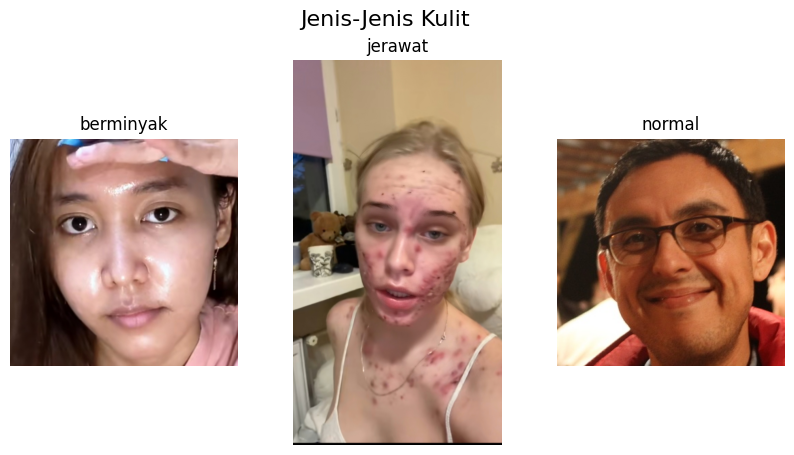

In [4]:
# Plot noken Images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle('Jenis-Jenis Kulit', fontsize=16)

# List of noken
noken_list = os.listdir(data_train)
# Plot images for each noken
for i, noken in enumerate(noken_list):
    dir_path = f'{data_train}/{noken}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    # row, col = divmod(i, 3)
    axes[i].imshow(img)
    axes[i].set_title(f'{noken}')
    axes[i].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(noken_list), 9):
    row, col = divmod(jj, 3)
    axes[i].axis('off')

plt.show()

In [5]:
BATCH_SIZE=32
IMAGE_SIZE=224
LABEL_MODE='categorical'

# Prepare the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Prepare the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Prepare the validation set
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_test,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 2682 files belonging to 3 classes.
Found 336 files belonging to 3 classes.
Found 336 files belonging to 3 classes.


In [ ]:
FILL_MODE = 'reflect'

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomHeight(0.1), 
    tf.keras.layers.RandomWidth(0.1),  
])


In [7]:
# Fungsi preprocessing untuk MobileNetV2
def preprocess_train(images, labels):
    images = data_augmentation(images, training=True)
    images = preprocess_input(images)  
    return images, labels

def preprocess_val(images, labels):
    images = preprocess_input(images)
    return images, labels

# Terapkan ke dataset
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
#Optimasi
SHUFFLE_BUFFER_SIZE=500
PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

train_dataset_final=(
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

test_dataset_final=(
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [9]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = True

# Fine-tune 30 layer terakhir
fine_tune_at = len(base_model.layers) - 40 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

def create_model(base_model):
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)


In [10]:
model = create_model(base_model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 1,846,147 (7.04 MB)

 Non-trainable params: 576,704 (2.20 MB)

In [11]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
       
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if train_accuracy >= 0.95 and val_accuracy >= 0.95:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 95% validation accuracy, so cancelling training!")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


In [ ]:
# Constant for epochs
EPOCHS = 100
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Mulai menghitung waktu
start_time = time.time()

# Train the model
history = model.fit(
    train_dataset_final,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=validation_dataset_final,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3867 - loss: 1.5121 - val_accuracy: 0.4137 - val_loss: 1.1156 - learning_rate: 1.0000e-05
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5981 - loss: 0.9688 - val_accuracy: 0.5238 - val_loss: 0.9579 - learning_rate: 1.0000e-05
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7110 - loss: 0.7001 - val_accuracy: 0.5863 - val_loss: 0.8816 - learning_rate: 1.0000e-05
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7537 - loss: 0.5672 - val_accuracy: 0.6429 - val_loss: 0.8289 - learning_rate: 1.0000e-05
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8355 - loss: 0.4352 - val_accuracy: 0.6815 - val_loss: 0.7664 - learning_rate: 1.0000e-05
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8754 - loss: 0.3712 - val_accuracy: 0.7321 - val_loss: 0.6961 - learning_rate: 1.0000e-05
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0

In [ ]:
#Berhenti menghitung waktu
end_time = time.time()

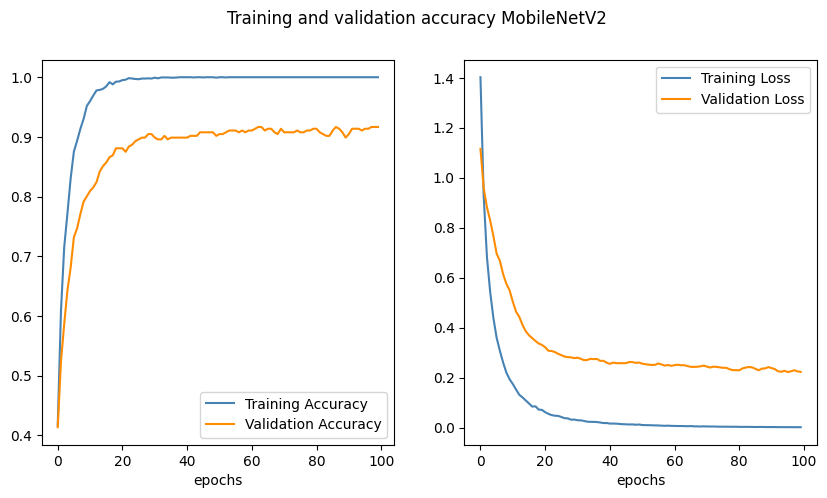

In [14]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy MobileNetV2')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'steelblue', label="Training " + label)
    ax[i].plot(epochs, data[1], 'darkorange', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

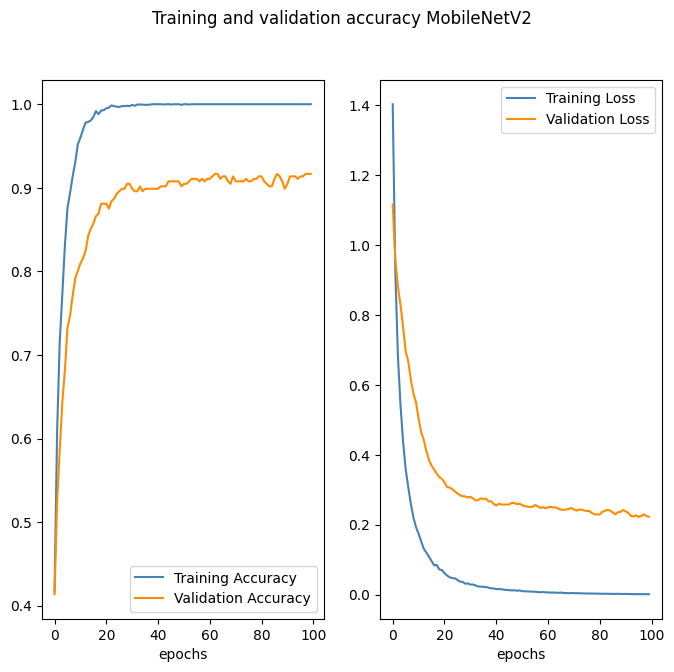

In [15]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(8, 7))
fig.suptitle('Training and validation accuracy MobileNetV2')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'steelblue', label="Training " + label)
    ax[i].plot(epochs, data[1], 'darkorange', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [16]:
import os

# Hitung jumlah file pada masing-masing dataset
num_train_files = sum([len(files) for _, _, files in os.walk(data_train)])
num_val_files = sum([len(files) for _, _, files in os.walk(data_validation)])
num_test_files = sum([len(files) for _, _, files in os.walk(data_test)])

# Hitung jumlah langkah (batches) untuk evaluasi
num_train_steps = num_train_files // BATCH_SIZE
num_val_steps = num_val_files // BATCH_SIZE
num_test_steps = num_test_files // BATCH_SIZE

# Evaluasi model
train_loss, train_acc = model.evaluate(train_dataset_final, steps=num_train_steps, verbose=1)
val_loss, val_acc = model.evaluate(validation_dataset_final, steps=num_val_steps, verbose=1)
test_loss, test_acc = model.evaluate(test_dataset_final, steps=num_test_steps, verbose=1)

# Print hasil evaluasi
print(f"Train Loss: {train_loss * 100:.2f} %")
print(f"Train Accuracy: {train_acc * 100:.2f} %")
print(f"Validation Loss: {val_loss * 100:.2f} %")
print(f"Validation Accuracy: {val_acc * 100:.2f} %")
print(f"Test Loss: {test_loss * 100:.2f} %")
print(f"Test Accuracy: {test_acc * 100:.2f} %")


83/83 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9985 - loss: 0.0119
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9326 - loss: 0.1752
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9063 - loss: 0.2278
Train Loss: 1.28 %
Train Accuracy: 99.70 %
Validation Loss: 22.75 %
Validation Accuracy: 91.56 %
Test Loss: 20.77 %
Test Accuracy: 91.56 %


In [ ]:
duration = end_time_no_optim - start_time_no_optim
minutes, seconds = divmod(duration, 60)
print(f"Waktu eksekusi: {int(minutes)} menit {seconds:.2f} detik")

Waktu eksekusi: 188 menit 0.30 detik


Found 2682 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


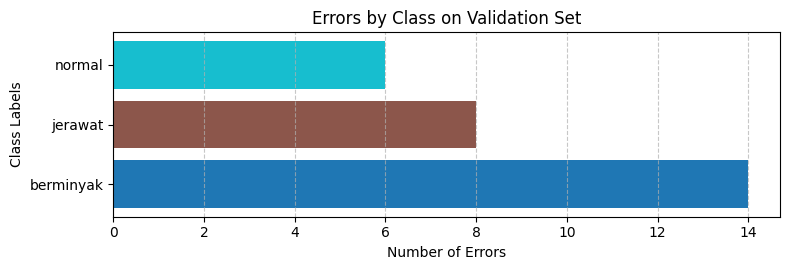

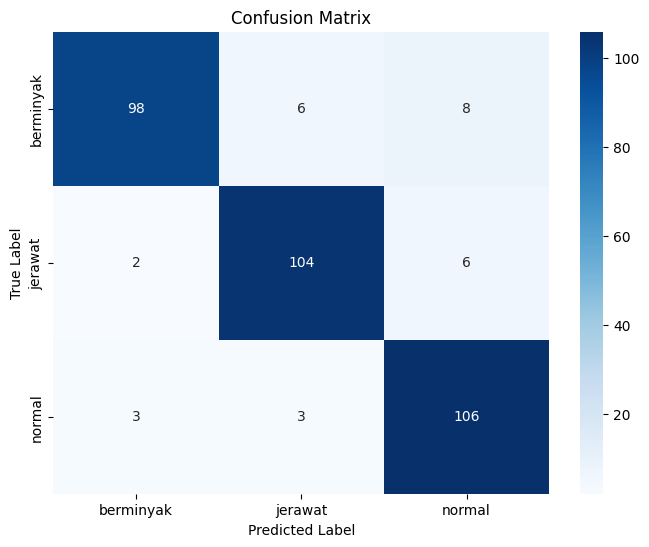

Classification Report:
              precision    recall  f1-score   support

   berminyak       0.95      0.88      0.91       112
     jerawat       0.92      0.93      0.92       112
      normal       0.88      0.95      0.91       112

    accuracy                           0.92       336
   macro avg       0.92      0.92      0.92       336
weighted avg       0.92      0.92      0.92       336



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)
import tensorflow as tf

raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int', 
    seed=42
)
class_names = raw_train_dataset.class_names

y_true = []
y_pred = []

# Iterasi melalui dataset validasi
for images, labels in validation_dataset_final:
    preds = model.predict(images)  
    
    if labels.shape[-1] > 1:
        labels = tf.argmax(labels, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


conf_matrix = confusion_matrix(y_true, y_pred)

# --- Error per class ---
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
filtered_labels = [label for label, errors in zip(class_names, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

# --- Visualisasi Errors by Class ---
if len(filtered_labels) > 0:
    colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_labels)))
    plt.figure(figsize=(8, len(filtered_labels) * 0.6 + 1))
    plt.barh(filtered_labels, filtered_errors, color=colors)
    plt.title('Errors by Class on Validation Set', fontsize=12)
    plt.xlabel('Number of Errors', fontsize=10)
    plt.ylabel('Class Labels', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kelas yang memiliki error!")

# --- Confusion Matrix Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [23]:
model.save('amorcare_mobilenetv2.h5')